# CellRank Meets CytoTRACE

## Preliminaries

In this tutorial, you will learn how to:

- compute a developmental potential using our adapted CytoTRACE implementation {cite}`gulati:20`. 
- set up CellRank's {class}`~cellrank.kernels.CytoTRACEKernel` to compute a transition matrix based on the CytoTRACE score. 
- visualize the transition matrix in a low-dimensional embedding. 

This tutorial notebook can be downloaded using the following [link](https://github.com/theislab/cellrank_notebooks/raw/main/tutorials/cellrank_meets_cytotrace.ipynb).

:::{figure-md} fig-intro

<img src="../_static/img/004_cytotrace_score.jpg" width="800px"  alt="CytoTRACE uses the number of genes expressed per cell to estimate a developmental potential.">

**CytoTRACE estimates differentiation potential**: Following the original CytoTRACE suggestion, we use the number of genes expressed per cell as a raw signal of differentiation status and apply several post-processing steps to increase robustness. The basic assumption behind this method is that naive cells on average express more genes compared to mature cells because they regulate their chromatin less tightly; we've observed this to work well for many early developmental datasets.  

:::

:::{note}

A bottleneck in the original implementation was scalabilty of the post-processing steps {cite}`gulati:20`; we therefore adapted the original CytoTRACE implementation to be much faster and memory efficient. We confirmed across several examples that our reimplementation yields biologically equivalent results (CITE). To get from the CytoTRACE pseudotime to a directed transition matrix, we use the general mechanism described in the {doc}`pseudotime tutorial <cellrank_meets_pseudotime>`. 

:::

:::{note}

If you want to run this on your own data, you will need:

- a scRNA-seq dataset which satisfies the CytoTRACE assumptions, i.e., naive cell states should on avarage express more genes. This is often the case for early develpmental stages. 

:::

:::{note}

If you encounter any bugs in the code, our if you have suggestions for new features, please open an [issue](https://github.com/theislab/cellrank/issues/new/choose). If you have a general question or something you would like to discuss with us, please post on the [scverse discourse](https://discourse.scverse.org/c/ecosytem/cellrank/40). You can also contact us using info@cellrank.org.  

:::

### Import packages & data

In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/theislab/cellrank

In [2]:
import cellrank as cr
import scanpy as sc
import scvelo as scv

cr.settings.verbosity = 2
sc.settings.set_figure_params(frameon=False, dpi=100)

Global seed set to 0


In [3]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)

To demonstrate the appproach in this tutorial, we will use a scRNA-seq dataset of zebrafish embryogenesis assayed using drop-seq, restricted to the axial mesoderm lineage {cite}`farrell:18`. This dataset can be acessed conveniently using {mod}`~cellrank.datasets.zebrafish`. 

In [4]:
adata = cr.datasets.zebrafish()
adata

AnnData object with n_obs × n_vars = 2434 × 23974
    obs: 'Stage', 'gt_terminal_states', 'lineages'
    uns: 'Stage_colors', 'gt_terminal_states_colors', 'lineages_colors'
    obsm: 'X_force_directed'

### Explore the data

This zebrafish dataset contains 12 time-points spanning 3.3 - 12 hours past fertilization. We can use the original force-directed layout to plot cells, colored by developmental stage:

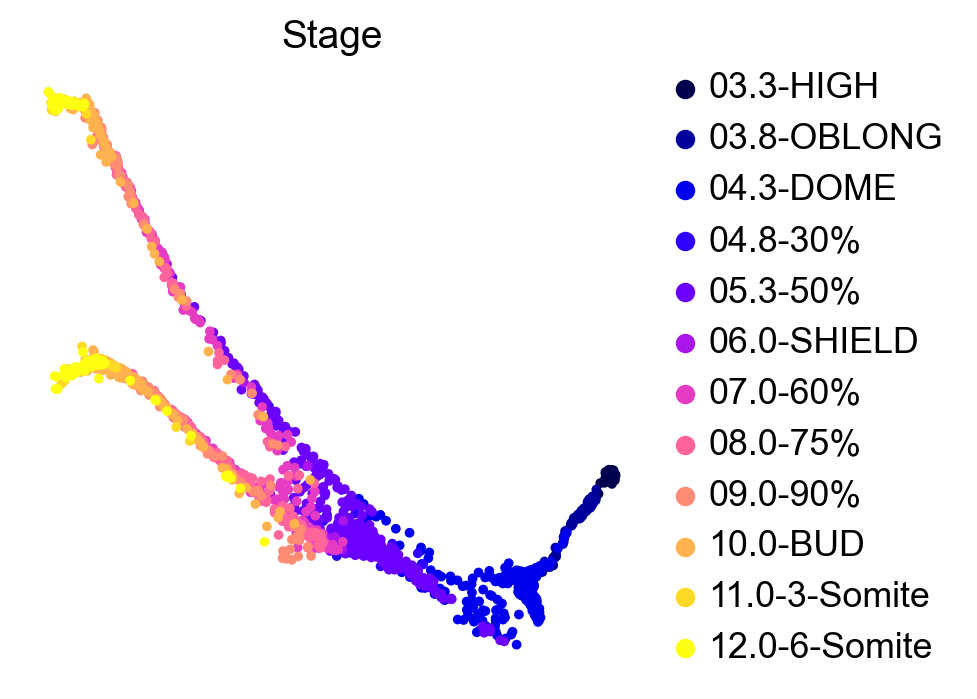

In [5]:
sc.pl.embedding(adata, basis="force_directed", color="Stage")

We can further look into the lineage assignments, computed in the original study using URD {cite}`farrell:18`: 

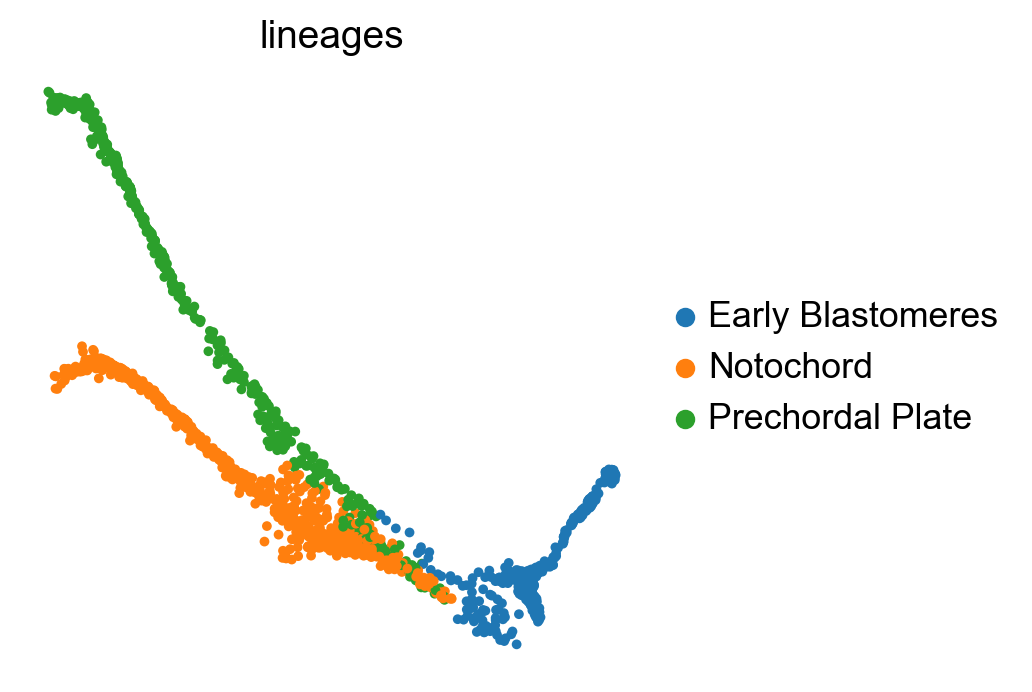

In [6]:
sc.pl.embedding(adata, basis="force_directed", color="lineages")

### Preprocess

Before we can start applying the CytoTRACE kernel, we'll have to do some basic preprocessing of the data. 

In [7]:
# filter, normalize total counts and log-transform
sc.pp.filter_genes(adata, min_cells=10)
scv.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

# hvg annotation
sc.pp.highly_variable_genes(adata)
print(f"This detected {adata.var['highly_variable'].sum()} highly variable genes. ")

Normalized count data: X.
This detected 2392 highly variable genes. 


CytoTRACE uses imputed gene expression to calculate the score of differentiation potential. Here, we use use {func}`scvelo.pp.moments` for imputation. We're copying our {attr}`~anndata.AnnData.X` matrix into the layers because that's where {func}`~scvelo.pp.moments` expects to find counts for imputation. 

In [8]:
adata.layers["spliced"] = adata.X
adata.layers["unspliced"] = adata.X
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


## Use developmental potential to direct differentiation

### Compute the CytoTRACE score

Import the {class}`~cellrank.kernels.CytoTRACEKernel`, initialize it using the preprocessed {class}`~anndata.AnnData` object and compute the CytoTRACE score: 

In [9]:
from cellrank.kernels import CytoTRACEKernel

ctk = CytoTRACEKernel(adata).compute_cytotrace()

Computing CytoTRACE score with `13690` genes
Adding `adata.obs['ct_score']`
       `adata.obs['ct_pseudotime']`
       `adata.obs['ct_num_exp_genes']`
       `adata.var['ct_gene_corr']`
       `adata.var['ct_correlates']`
       `adata.uns['ct_params']`
    Finish (0:00:00)


We can visually check that our computed CytoTRACE pseudotime correlates well with ground-truth real-time annotations:

/Users/marius/miniforge3/envs/py39_arm_cr/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


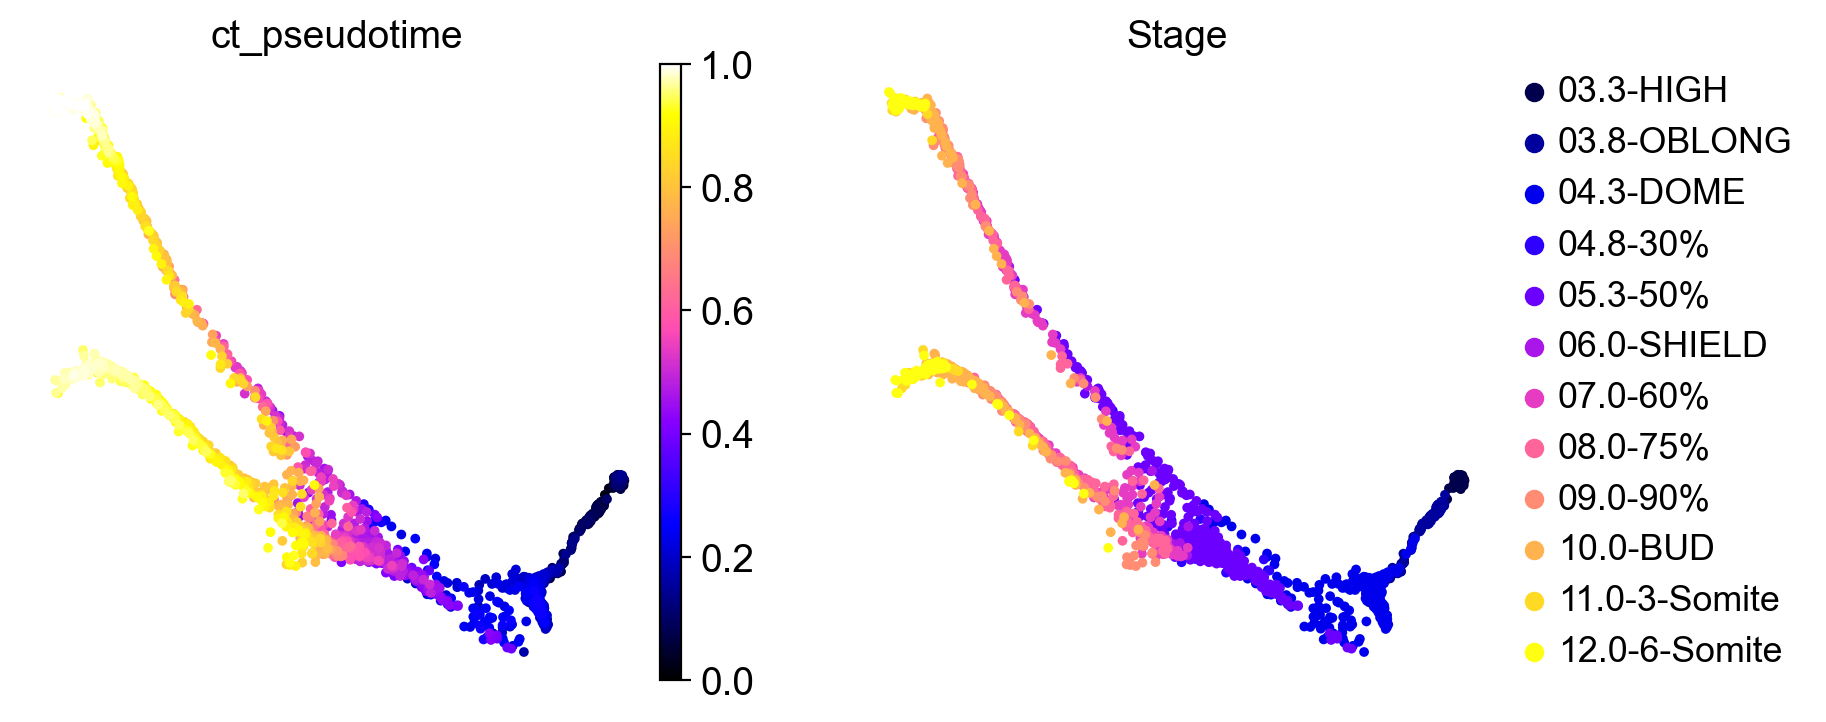

In [10]:
sc.pl.embedding(
    adata,
    color=["ct_pseudotime", "Stage"],
    basis="force_directed",
    color_map="gnuplot2",
)

To make this a bit more quantitative, we can look at the distribution of our CytoTRACE pseudotime over real time points and show this via violin plots:

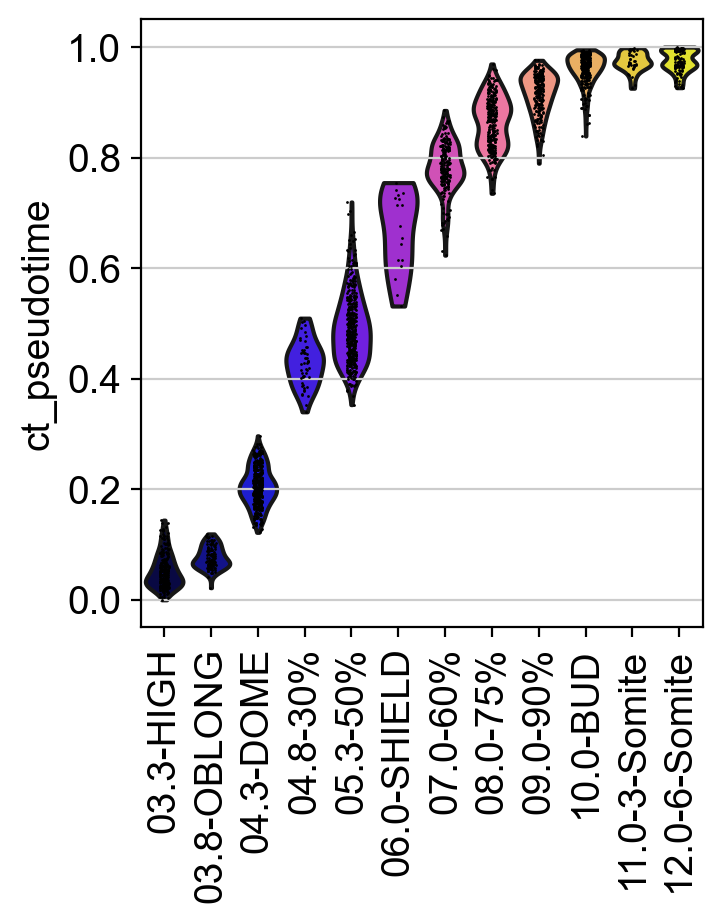

In [11]:
sc.pl.violin(adata, keys=["ct_pseudotime"], groupby="Stage", rotation=90)

As expected, the CytoTRACE pseudotime increases for later time points. Thus, we can use this score to bias graph edges into the direction of increasing differentiation status, similar to how we do this for other pseudotimes with the {class}`~cellrank.kernels.PseudotimeKernel`. 

### Compute & visualize a transition matrix

Compute the transition matrix using {meth}`~cellrank.kernels.CytoTRACEKernel.compute_transition_matrix`. 

In [12]:
ctk.compute_transition_matrix(threshold_scheme="soft", nu=0.5)

Computing transition matrix based on pseudotime`


  0%|          | 0/2434 [00:00<?, ?cell/s]

    Finish (0:00:00)


CytoTRACEKernel[n=2434, dnorm=False, scheme='soft', b=10.0, nu=0.5]

To get some intuition for this transition matrix, we can project it into an embedding and draw streamlines - the following plot will look like the plots you're used to from scVelo and velocyto for visualizing RNA velocity {cite}`bergen:20,manno:18`. 

:::{note}

There's **no RNA velocity** here, we're visualizing the directed transition matrix we computed using the kNN graph as well as the CytoTRACE pseudotime.

:::

Projecting transition matrix onto `force_directed`
Adding `adata.obsm['T_fwd_force_directed']`
    Finish (0:00:00)


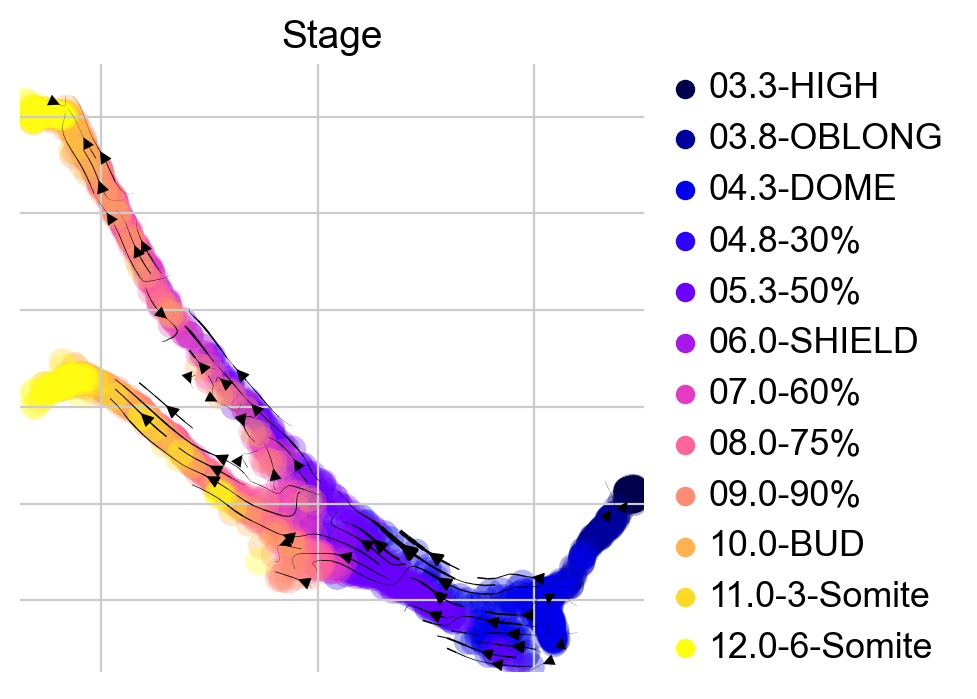

In [13]:
ctk.plot_projection(basis="force_directed", color="Stage", legend_loc="right")

Visually, in the low-dimensional space, the process of differentiation seems to be captured well by this transition matrix. We can visually "confirm" this by looking at terminal-state annotations from the original study: 

/Users/marius/miniforge3/envs/py39_arm_cr/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:163: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = copy(get_cmap(cmap))


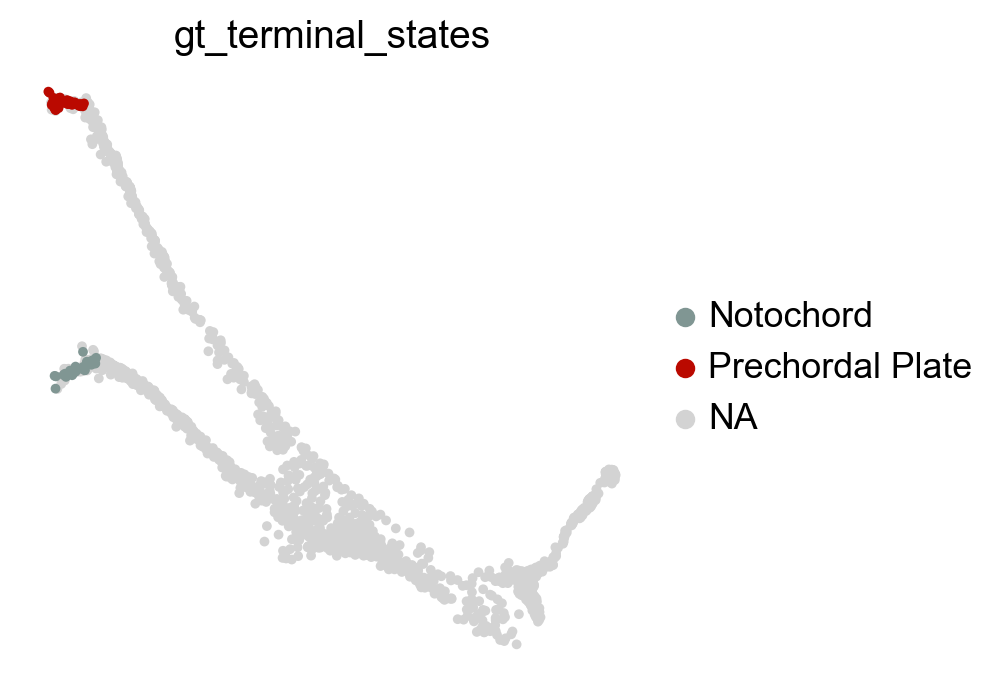

In [14]:
sc.pl.embedding(adata, basis="force_directed", color="gt_terminal_states")

Another way to gain intuition for the transition matrix is by drawing some cells from the early stage and to use these as starting cells to simulate random walks on the transition matrix. This visualization technique is less biased by the low-dimensional embedding as the random walks are computed directly based on the transition matrix. 

Simulating `100` random walks of maximum length `609`


  0%|          | 0/100 [00:00<?, ?sim/s]

    Finish (0:00:03)
Plotting random walks


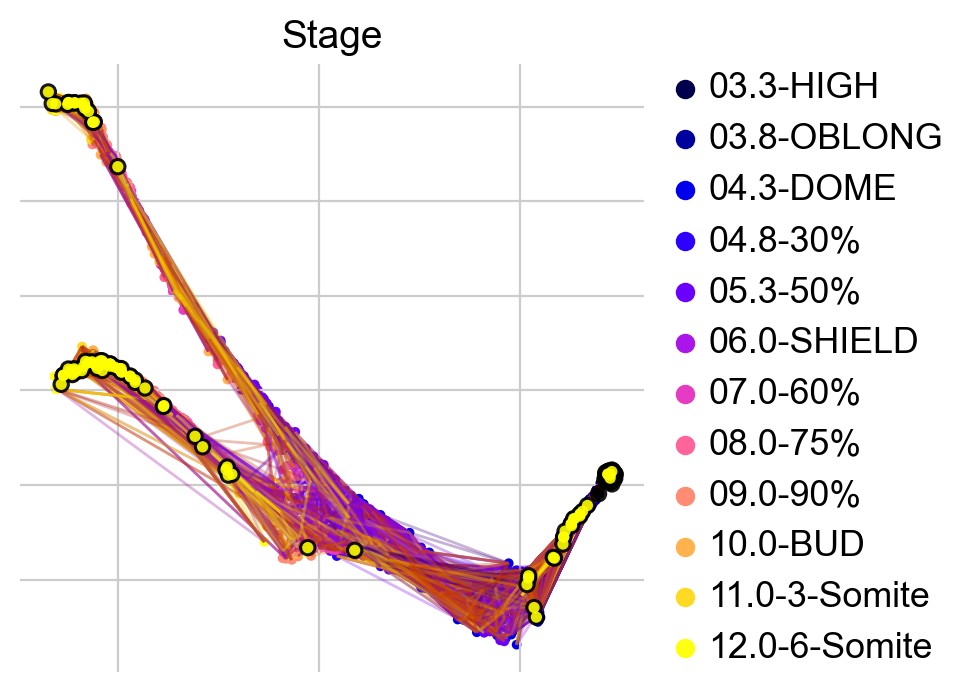

In [15]:
ctk.plot_random_walks(
    n_sims=100,
    start_ixs={"Stage": "03.3-HIGH"},
    basis="force_directed",
    color="Stage",
    legend_loc="right",
    seed=1,
)

Black dots denote sampled starting cells for random walks, yellow dots denote end cells. We terminated each random walk after a predefined number of steps. Random walks are colored according to how long they've been running for - i.e. the initial segments are more black/blue whereas the late segments are more orange/yellow. We can see that many random walks terminate in one of the two terminal states, as expected. Quite a few of them seem to get stuck early on, this could be further investigated. 

:::{note}

The visualization techniques demonstrated here work for **every kernel**, no matter whether it's a {class}`~cellrank.kernels.VelocityKernel`, {class}`~cellrank.kernels.PseudotimeKernel`, {class}`CytoTRACEKernel` or some other CellRank {mod}`kernel <cellrank.kernels>`. 

:::

## Closing matters

### What's next? 

In this tutorial, you learned how to use CellRank to compute a transition matrix based on the CytoTRACE pseudotime and how it can be visualized in low dimensions. The real power of CellRank comes in when you use estimators to analyze the transition matrix directly, rather than projecting it. For the next steps, we recommend to:

- go through the {doc}`initial and terminal states tutorial <initial_terminal>` to learn how to use the transition matrix to automatically identify initial and terminal states. 
- take a look at the {class}`API <cellrank.kernels.CytoTRACEKernel>` to learn about parameter values you can use to adapt these computations to your data. 
- read the original CytoTRACE publication and considering limitations of this appraoch {cite}`gulati:20`. 

### Package versions

In [16]:
cr.logging.print_versions()

cellrank==1.5.1+gedbc651e scanpy==1.9.3 anndata==0.8.0 numpy==1.24.2 numba==0.57.0rc1 scipy==1.10.1 pandas==1.5.3 pygpcca==1.0.4 scikit-learn==1.1.3 statsmodels==0.13.5 python-igraph==0.10.4 scvelo==0.3.0 pygam==0.8.0 matplotlib==3.7.0 seaborn==0.12.2
